In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

r_cols = ['userId', 'itemId', 'rating', 'timestamp']
data = pd.read_csv('../data/ml-100k/u.data', sep='\t', names=r_cols)

n_users = data['userId'].max() + 1
n_items = data['itemId'].max() + 1

print(f'Number users: {n_users}')
print(f'Number items: {n_items}')

Number users: 944
Number items: 1683


In [3]:
# Tạo label: tất cả các rating hiện có đều là positive (1)
data['label'] = 1

# Tạo tập hợp tất cả các item để lấy mẫu ngẫu nhiên
all_movie_ids = data['itemId'].unique()

# Tạo tập hợp các item đã xem cho mỗi user để kiểm tra nhanh
user_watched_movies = data.groupby('userId')['itemId'].apply(set)

# Tạo negative samples
negative_samples = []
for user_id, watched_set in user_watched_movies.items():
    num_negative_samples = len(watched_set)
    unwatched_items = set(all_movie_ids) - watched_set
    
    try:
        neg_items = np.random.choice(list(unwatched_items), size=num_negative_samples, replace=False)
    except ValueError:
        continue

    for item_id in neg_items:
        negative_samples.append({'userId': user_id, 'itemId': item_id, 'rating': 0, 'timestamp': 0, 'label': 0})

# Kết hợp positive và negative samples
full_data = pd.concat([data, pd.DataFrame(negative_samples)], ignore_index=True)
full_data = full_data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dữ liệu sau khi thêm negative samples:")
display(full_data.head())

Dữ liệu sau khi thêm negative samples:


,userId,itemId,rating,timestamp,label
0,200,1122,0,0,0
1,790,431,3,885157159,1
2,516,665,0,0,0
3,426,1020,4,879442702,1
4,455,694,4,879110870,1


In [4]:
class MovieLensDataset(Dataset):
  def __init__(self, users, items, labels):
    self.users = torch.tensor(users, dtype=torch.long)
    self.items = torch.tensor(items, dtype=torch.long)
    self.labels = torch.tensor(labels, dtype=torch.float32)
  
  def __len__(self):
    return len(self.users)
  
  def __getitem__(self, index):
    return self.users[index], self.items[index], self.labels[index]

In [6]:
class GMF(nn.Module):
  def __init__(self, num_users, num_items, latent_dim=8, reg=0.01):
    super(GMF, self).__init__()
    
    self.user_embedding = nn.Embedding(num_users, latent_dim)
    self.item_embedding = nn.Embedding(num_items, latent_dim)
    
    self.prediction_layer = nn.Linear(latent_dim, 1)
    
    self.sigmoid = nn.Sigmoid()
    
    self._init_weights()
    
  def _init_weights(self):
    nn.init.normal_(self.user_embedding.weight, std=0.01)
    nn.init.normal_(self.item_embedding.weight, std=0.01)
    nn.init.xavier_uniform_(self.prediction_layer.weight)
    self.prediction_layer.bias.data.fill_(0.0)
  
  def forward(self, user_ids, item_ids):
    user_vec = self.user_embedding(user_ids)
    item_vec = self.item_embedding(item_ids)
    
    gmf_vector = user_vec * item_vec
    
    prediction = self.prediction_layer(gmf_vector)
    
    output = self.sigmoid(prediction)
    
    return output.squeeze()

latent_dim = 16
model = GMF(n_users, n_items, latent_dim=latent_dim)
print(model)

GMF(
  (user_embedding): Embedding(944, 16)
  (item_embedding): Embedding(1683, 16)
  (prediction_layer): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [9]:
train_data, val_data = train_test_split(full_data, test_size=0.2, random_state=42)

train_dataset = MovieLensDataset(train_data['userId'].values, train_data['itemId'].values, train_data['label'].values)
val_dataset = MovieLensDataset(val_data['userId'].values, val_data['itemId'].values, val_data['label'].values)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 10
history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_acc': []}

print("GMF is training...")
for epoch in range(epochs):
  model.train()
  total_train_loss = 0
  
  for users, items, labels in train_loader:
    users, items, labels = users.to(device), items.to(device), labels.to(device)
    
    optimizer.zero_grad()
    
    outputs = model(users, items)
    
    loss = criterion(outputs, labels)
    
    loss.backward()
    
    optimizer.step()
    
    total_train_loss += loss.item()
  avg_train_loss = total_train_loss / len(train_loader)
  history['train_loss'].append(avg_train_loss)
  
  # --- Đánh giá trên tập validation ---
  model.eval() # Chuyển sang chế độ đánh giá
  total_val_loss = 0
  all_labels = []
  all_preds = []
  
  with torch.no_grad(): # Không cần tính gradient khi đánh giá
    for users, items, labels in val_loader:
      users, items, labels = users.to(device), items.to(device), labels.to(device)
      outputs = model(users, items)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()
      
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(outputs.cpu().numpy())
      
  avg_val_loss = total_val_loss / len(val_loader)
  val_auc = roc_auc_score(all_labels, all_preds)
  val_acc = np.mean((np.array(all_preds) > 0.5) == np.array(all_labels))

  history['val_loss'].append(avg_val_loss)
  history['val_auc'].append(val_auc)
  history['val_acc'].append(val_acc)
  
  print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_acc:.4f} - Val AUC: {val_auc:.4f}")

GMF is training...
Epoch 1/10 - Train Loss: 0.6348 - Val Loss: 0.5125 - Val Acc: 0.7623 - Val AUC: 0.8452
Epoch 2/10 - Train Loss: 0.4827 - Val Loss: 0.4773 - Val Acc: 0.7677 - Val AUC: 0.8520
Epoch 3/10 - Train Loss: 0.4674 - Val Loss: 0.4721 - Val Acc: 0.7694 - Val AUC: 0.8540
Epoch 4/10 - Train Loss: 0.4610 - Val Loss: 0.4668 - Val Acc: 0.7726 - Val AUC: 0.8573
Epoch 5/10 - Train Loss: 0.4517 - Val Loss: 0.4558 - Val Acc: 0.7815 - Val AUC: 0.8650
Epoch 6/10 - Train Loss: 0.4345 - Val Loss: 0.4383 - Val Acc: 0.7955 - Val AUC: 0.8769
Epoch 7/10 - Train Loss: 0.4124 - Val Loss: 0.4210 - Val Acc: 0.8070 - Val AUC: 0.8875
Epoch 8/10 - Train Loss: 0.3927 - Val Loss: 0.4089 - Val Acc: 0.8145 - Val AUC: 0.8945
Epoch 9/10 - Train Loss: 0.3785 - Val Loss: 0.4021 - Val Acc: 0.8186 - Val AUC: 0.8981
Epoch 10/10 - Train Loss: 0.3683 - Val Loss: 0.3972 - Val Acc: 0.8224 - Val AUC: 0.9008


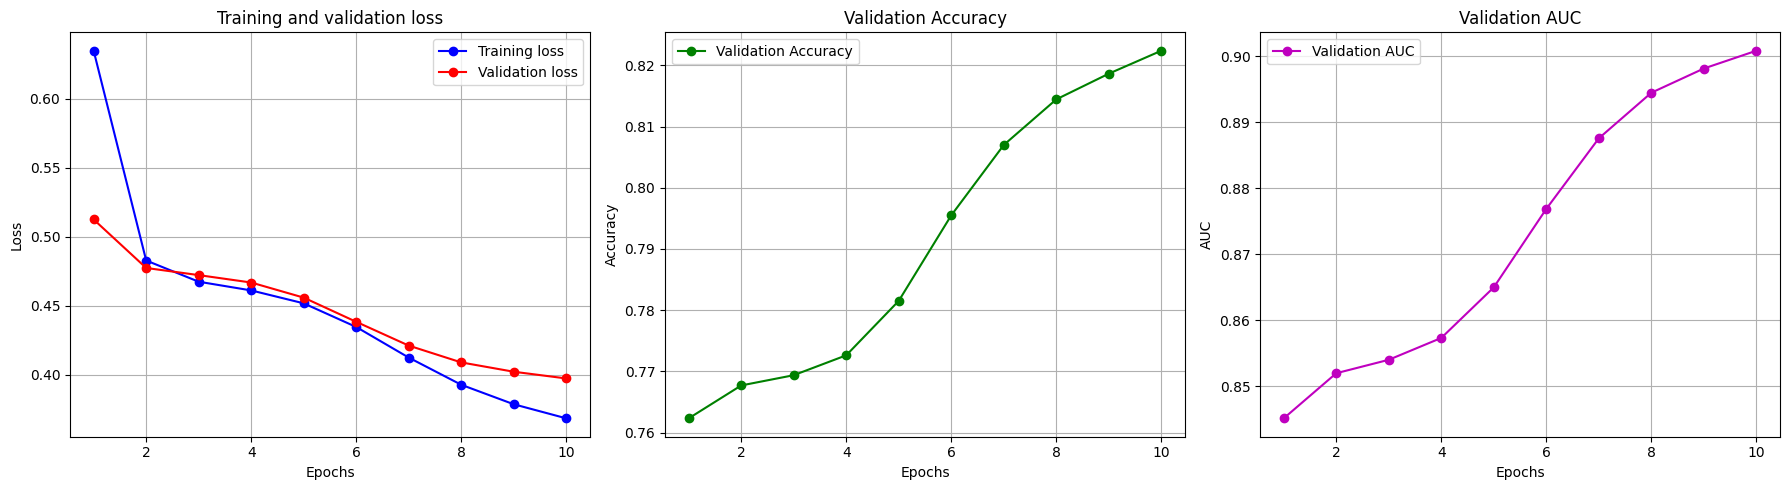

In [10]:
# Trực quan hóa quá trình học
def plot_history_pytorch(history):
  epochs = range(1, len(history['train_loss']) + 1)

  plt.figure(figsize=(18, 5))
  
  # Vẽ đồ thị loss
  plt.subplot(1, 3, 1)
  plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
  plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  
  # Vẽ đồ thị accuracy
  plt.subplot(1, 3, 2)
  plt.plot(epochs, history['val_acc'], 'go-', label='Validation Accuracy')
  plt.title('Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  
  # Vẽ đồ thị AUC
  plt.subplot(1, 3, 3)
  plt.plot(epochs, history['val_auc'], 'mo-', label='Validation AUC')
  plt.title('Validation AUC')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

plot_history_pytorch(history)